# Generative Adversarial Networks (GANs)

A generative adversarial network (GAN) is a machine learning framework consisting of two ANNs that compete with each other in a zero-sum game. These two sub-networks are commonly seen as the *generator (G)* and the *discriminator (D)* respectively.

<img src="./images/gan.png" width="60%" align="center">

In this notebook, we will explore a simple GAN architecture that learns to generate synthetic handwritten digits based on the MNIST dataset.

## A High-Level Overview

Generative adversarial networks are so named because they consist of two components, the generator and the discriminator, that are pitted against each other in a competitive training process. The generator is tasked with generating realistic samples, while the discriminator is trained to distinguish between real and fake samples. As training progresses, the generator improves its ability to create samples that can fool the discriminator, while the discriminator becomes better at identifying generated samples.

When *D* successfully identifies real and fake samples, it is rewarded (or no change is needed to its model parameters) while *G* is penalized with large updates to its corresponding parameters. Similarly, when *G* fools *D*, it is rewarded (or no change is needed to its parameters), but *D* is penalized and its model parameters are updated. In the idealized case, *G* generates perfect replicas from the input domain and *D* cannot tell the difference between real and synthetic data, so its prediction is totally random (50%).

### The Discriminator Network (D)

The discriminator is fed with either real samples from the training dataset or generated samples provided by the generator. Its role is to estimate the probability that the input belongs to the real dataset. The training is performed so that the discriminator outputs '1' when a real sample is given and '0' when a generated sample is fed to its input. For this purpose, we will use a common feed-forward neural network that is trained with the backpropagation algorithm and the *binary cross-entropy* as the cost function. The binary cross-entropy is defined as

$$ C(y,\hat{y} ; \theta) = \frac{1}{B} \sum_{i=1}^B \left ( -y^{(i)}\ln(\hat{y}^{(i)}) - (1-y^{(i)})\ln(1-\hat{y}^{(i)}) \right) $$

where $y^{(i)}$ is the target label of the $i$-th sample, $\hat{y}^{(i)}$ is the network output for the $i$-th sample with parameters $\theta$ (weights and biases) and $B$ is the number of samples in a batch.

It is convenient to use the cross-entropy function for binary classification when the network output corresponds to a probability.

### The Generator Network (G)

The generator component is supplied with a set of randomly generated data points from a latent space. Its primary objective is to produce synthetic data samples that closely resemble the actual samples found in the dataset. To achieve this, the generator learns to capture the underlying patterns and features of the real data, which it then uses to generate convincing new samples. For this purpose, we will also use a feed-forward neural network with various activation functions.

### Training Process

Generative adversarial networks employ a unique training process that involves a two-player *minimax* game. During training, the discriminator component is optimized to accurately distinguish between real and generated samples, while the generator component is optimized to create synthetic samples that closely resemble the real ones. This process results in a competition between the two components, where the generator aims to produce samples that can fool the discriminator, while the discriminator tries to correctly identify whether a given sample is real or fake. Ultimately, the goal is to train the generator to maximize the probability that the discriminator makes a mistake when trying to differentiate between real and synthetic samples.


The training process involves updating the parameters of the discriminator and generator components in an iterative manner. During each training step, a batch of labeled real and generated samples is fed into the model and the parameters of the discriminator are updated to minimize a loss function that measures its ability to discriminate between real and synthetic samples. Once the discriminator has been updated, the generator is trained to produce more realistic samples by maximizing the probability that the discriminator makes a mistake when classifying generated data as real or fake. During this step, the output of the generator is connected to the discriminator which is kept constant while the generator is updated. By repeating this process over multiple training iterations, the model is able to learn the underlying patterns in the data and generate highly convincing synthetic samples.

## Implementation

For the purpose of this GAN, we will use the *MNIST* dataset of handwritten digits.

First, let us import the necessary frameworks and load the MNIST dataset and normalize it. We choose to normalize the pixel values in the interval [-1,1] because of the greyscale nature of the samples. By normalizing in this interval, most '0' values are eliminated and thus, we reduce the computational workload.

In [1]:
# hide tensorflow warnings on GPU execution (we will use CPU)
from silence_tensorflow import silence_tensorflow
silence_tensorflow()

import tensorflow as tf

from matplotlib import pyplot as plt
import numpy as np
import time
import random

# Load the Fashion-MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

training_data = x_train.astype('float32')/127.5 -1
test_data = x_test.astype('float32')/127.5 - 1

# Print the shape of the training data
print('Training data shape:', training_data.shape, y_train.shape)

# Print the shape of the testing data
print('Testing data shape:', test_data.shape, y_test.shape)

Training data shape: (60000, 28, 28) (60000,)
Testing data shape: (10000, 28, 28) (10000,)


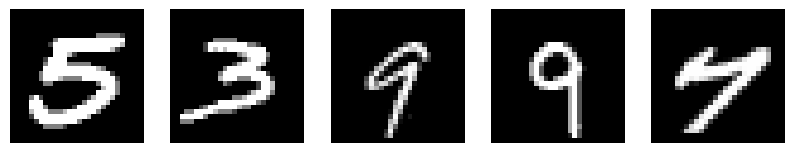

In [2]:
# Generate random samples of images to display (normalized)
num_images = 5
rand_idx = np.random.randint(training_data.shape[0], size=num_images)

# Display the images and their labels
fig, axes = plt.subplots(1, num_images, figsize=(10,10))
for i, ax in enumerate(axes):
    ax.imshow(training_data[rand_idx[i]], cmap='gray')
    ax.axis('off')

plt.show()

Now, let us define the **discriminator** using tensorflow. The output neuron uses the sigmoid activation because we want to represent a probability that the sample is either fake (probability to 0) or real (probability to 1). Also, we use the binary cross-entropy function along with Adam optimizer.

#### Notes on RELU activation

The *rectified linear unit (ReLU)* activation function is commonly used in the hidden layers of neural networks due to its several advantages over other activation functions. Here we outline some reasons for this:

 - Computationally Efficient: The ReLU function is efficient to compute compared to other activation functions such as the sigmoid or hyperbolic tangent functions. This is because it involves simple thresholding operations, whereas the sigmoid function requires more complex exponential calculations.
 - Avoids Vanishing Gradient Problem: The ReLU function can help to alleviate the vanishing gradient problem, which is a common issue in deep neural networks where the gradients become very small as they propagate through many layers. The ReLU function's derivative is either 1 or 0, which means that it does not saturate for positive inputs and this makes it more resistant to the vanishing gradient problem.
 - Sparse Activation: The ReLU function results in sparse activations, meaning that only a small subset of the neurons in a layer will be activated for a given input. This can lead to more efficient use of computation resources and can also help to prevent overfitting by reducing the interdependence of the neurons in a layer.
 - Better for Deep Networks: As neural networks get deeper, the ReLU function becomes more advantageous. Deep neural networks have a higher chance of experiencing the vanishing gradient problem and using ReLU can alleviate this problem while maintaining a good level of performance.

First, define the **discriminator** network that classifies samples as 'real' with '1' and 'fake' with '0'.

In [3]:
# Define the discriminator network
def build_discriminator():
    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=(28, 28)),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    opt = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5) 
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

Also, define the **generator**. The generator maps a random input of $\textit{latent_dim}$ features to an output of 784 features, which are the pixels (28x28) of a MNIST image. We use the *hyperbolic tangent function* in the output layer because we want the values to be in the range [-1, 1], as the output of the generator is also the input to the discriminator.

In [4]:
# Define the generator network
def build_generator(latent_dim):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(128, input_dim=latent_dim, activation='relu'),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(784, activation='tanh'),
        tf.keras.layers.Reshape((28, 28))
    ])
    return model

First, we need a function that generates $n$ latent points of $dim$ dimensions.

In [5]:
def generate_latent_points(n, dim):
    latent_points = np.random.randn(n * dim)  
    z_input = latent_points.reshape(n, dim)
    return z_input

The generator is used to generate $n$ fake data samples of $dim$ dimensions by feeding it with random noise. We label fake data with '0'.

In [6]:
def generate_fake_samples(generator, n, dim):
    latent_points = generate_latent_points(n, dim)
    fake_samples = generator.predict(latent_points, verbose=0)
    return fake_samples

Also, we define a helper function that partitions the dataset in batches of $\textit{BATCH_SIZE}$.

In [7]:
def part_batches(data, BATCH_SIZE):
    batches = [data[i:i+BATCH_SIZE] for i in range(0, len(data), BATCH_SIZE)]
    return batches

Last, define the hyperparameters and the **GAN** model:

In [8]:
# define the hyperparameters
EPOCHS = 50
BATCH_SIZE = 60
latent_dim = 100

# define the generator and discriminator models
generator = build_generator(latent_dim)
discriminator = build_discriminator()

# define the input for the generator
gen_input = tf.keras.layers.Input(shape=(latent_dim,))

# define the generated image using the generator model
gen_img = generator(gen_input)

# define the discriminator model to be trained with real and fake images
discriminator.trainable = False
discriminator_output = discriminator(gen_img)

# define the GAN model
gan = tf.keras.models.Model(inputs=gen_input, outputs=discriminator_output)
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5) 
gan.compile(loss='binary_crossentropy', optimizer=opt)

Now, we can move on training the GAN:

In [9]:
start_time = time.time()
print('Initiating GAN training...\n')
# define the training loop and train the GAN model
for epoch in range(EPOCHS):
    # shuffle the training set
    np.random.shuffle(training_data)
    for batch in part_batches(training_data, BATCH_SIZE):
        # generate fake samples using the generator
        fake_samples = generate_fake_samples(generator, BATCH_SIZE, latent_dim)
        # combine fake and real samples in a single batch of size [2xBATCH_SIZE]
        d_samples = np.concatenate([fake_samples, batch])
        # also, combine fake and real labels
        y_fake = np.zeros((BATCH_SIZE, 1))
        y_real = np.ones((BATCH_SIZE, 1))
        d_labels = np.concatenate([y_fake, y_real])
        
        # train the discriminator on the real and fake samples
        d_loss, _ = discriminator.train_on_batch(d_samples, d_labels)
        
        # generate new fake samples using the generator
        latent_points = generate_latent_points(BATCH_SIZE, latent_dim)
        labels = np.ones((BATCH_SIZE, 1))

        # train the generator to fool the discriminator
        g_loss = gan.train_on_batch(latent_points, labels)

    # print the losses and accuracies
    print(f"Epoch {epoch+1}: D loss={d_loss:.4f}, G loss={g_loss:.4f}")
exec_time = time.time() - start_time
print(f'\n GAN training completed. Training time: --- {exec_time:.02f} seconds ---')

Initiating GAN training...

Epoch 1: D loss=0.2389, G loss=2.5746
Epoch 2: D loss=0.3209, G loss=2.5569
Epoch 3: D loss=0.1515, G loss=3.2805
Epoch 4: D loss=0.3251, G loss=3.1813
Epoch 5: D loss=0.2776, G loss=3.0728
Epoch 6: D loss=0.3395, G loss=1.8268
Epoch 7: D loss=0.3265, G loss=1.9702
Epoch 8: D loss=0.4752, G loss=1.6734
Epoch 9: D loss=0.4162, G loss=1.5637
Epoch 10: D loss=0.4297, G loss=1.6166
Epoch 11: D loss=0.5099, G loss=1.5023
Epoch 12: D loss=0.4373, G loss=1.3850
Epoch 13: D loss=0.4760, G loss=1.3427
Epoch 14: D loss=0.4456, G loss=1.4459
Epoch 15: D loss=0.4200, G loss=1.5235
Epoch 16: D loss=0.4836, G loss=1.2807
Epoch 17: D loss=0.4630, G loss=1.3561
Epoch 18: D loss=0.5291, G loss=1.3524
Epoch 19: D loss=0.4977, G loss=1.1860
Epoch 20: D loss=0.4656, G loss=1.0554
Epoch 21: D loss=0.4678, G loss=1.0938
Epoch 22: D loss=0.4854, G loss=1.3887
Epoch 23: D loss=0.5289, G loss=1.1540
Epoch 24: D loss=0.4772, G loss=1.2355
Epoch 25: D loss=0.4993, G loss=1.1183
Epoch 

Plot some synthetic digits:

1/1 [==============================] - 2s 2s/step


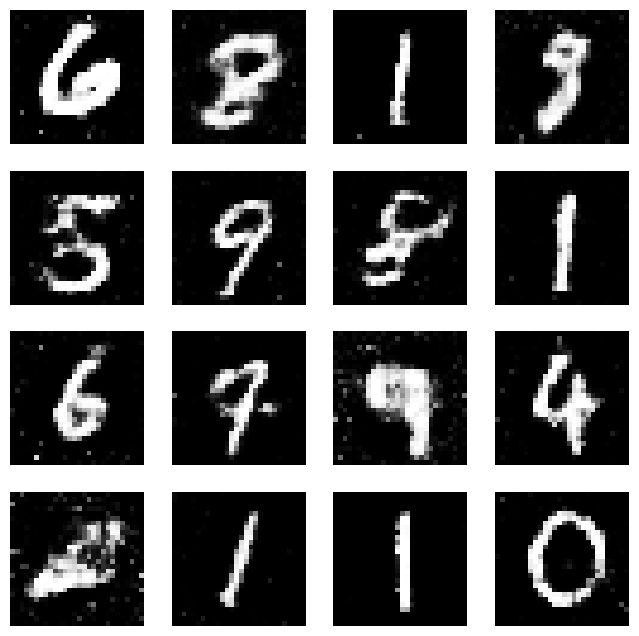

In [10]:
import matplotlib.pyplot as plt

# Generate 16 synthetic samples using the generator
latent_points = generate_latent_points(16, latent_dim)
synthetic_samples = generator.predict(latent_points)

# Create a 4x4 subplot
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(8, 8))

# Plot the generated images on the subplot
for i, ax in enumerate(axes.flat):
    ax.imshow(synthetic_samples[i], cmap='gray')
    ax.axis('off')
    
# Show the plot
plt.show()